<a href="https://colab.research.google.com/github/nandhukumar86/CapstonePneumoniaDetection/blob/main/DenseNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [4]:
dfData.head()

,patientId,x,y,width,height,Target,X,Y,Image256,Xo,Yo,xo,yo,widtho,heighto,Age,Sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1024,1024,"[[92, 50, 30, 17, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4...",256,256,NaN,NaN,NaN,NaN,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1024,1024,"[[20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",256,256,NaN,NaN,NaN,NaN,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1024,1024,"[[18, 16, 15, 15, 14, 14, 13, 14, 14, 14, 14, ...",256,256,NaN,NaN,NaN,NaN,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1024,1024,"[[205, 202, 193, 192, 187, 185, 180, 179, 177,...",256,256,NaN,NaN,NaN,NaN,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,1024,1024,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,...",256,256,66.0,38.0,54.0,95.0,32,F


In [5]:
from google.colab.patches import cv2_imshow

In [6]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon

def dice_coefficient(y_true, y_pred):
  numerator = 2 * reduce_sum(y_true * y_pred)
  denominator = reduce_sum(y_true + y_pred)

  return numerator / (denominator + epsilon())


def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [7]:
y_train = []
X_train = []
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  X_train.append(cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB))
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      mask = cv2.resize(mask,(32,32))
      j = j+1
  y_train.append(cv2.resize(mask,(8,8)))
  if (i%1000 == 0):
    print(i, " completed")
  # if (i==9999):
  #   break;
  i = i + 1

0  completed
1000  completed
2000  completed
3000  completed
4000  completed
5000  completed
6000  completed
7000  completed
8000  completed
9000  completed
10000  completed
11000  completed
12000  completed
13000  completed
14000  completed
15000  completed
16000  completed
17000  completed
18000  completed
19000  completed
20000  completed
21000  completed
22000  completed
23000  completed
24000  completed
25000  completed
26000  completed


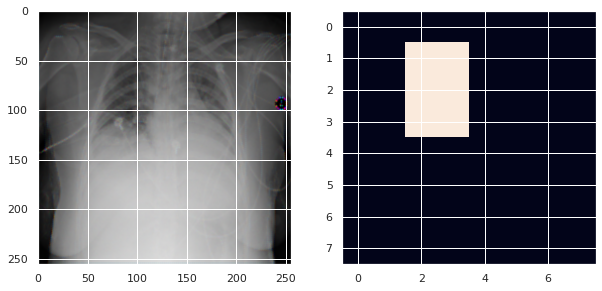

In [8]:
n = 4

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(X_train[n])
axes[1].imshow(y_train[n]);


In [ ]:
# X_train_1 = preprocess_input(np.array(X_train))
X_train_1 = np.array(X_train)/255
y_train_1 = np.array(y_train)/255

In [116]:
tensorflow.keras.backend.clear_session()

In [117]:
model = DenseNet121(input_shape=(256,256,3),include_top=False,weights='imagenet')

for l in model.layers:
  l.trainable = False;

In [118]:
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [106]:
layer8x8 = model.get_layer('conv5_block16_1_relu').output
layer16x16 = model.get_layer('pool4_relu').output
layer32x32 = model.get_layer('pool3_conv').output

x = Concatenate()([UpSampling2D()(layer8x8),layer16x16])
x = Concatenate()([UpSampling2D()(x),layer32x32])

x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
model = Model(model.input, x)

model.compile(optimizer='adam', loss=loss, metrics=[dice_coefficient])

# pass callback as property during fit: callbacks=[earlystop]
earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='dice_coefficient', patience=5, min_delta=0.01)

model.fit(X_train_1, y_train_1, epochs=50, batch_size=8, verbose=1, callbacks=[earlystop]) 

Epoch 1/50
1250/1250 [==============================] - 30s 19ms/step - loss: 4.0913 - dice_coefficient: 0.1322
Epoch 2/50
1250/1250 [==============================] - 24s 19ms/step - loss: 3.5127 - dice_coefficient: 0.2114
Epoch 3/50
1250/1250 [==============================] - 24s 19ms/step - loss: 3.3377 - dice_coefficient: 0.2421
Epoch 4/50
1250/1250 [==============================] - 24s 19ms/step - loss: 3.3634 - dice_coefficient: 0.2601
Epoch 5/50
1250/1250 [==============================] - 24s 19ms/step - loss: 3.4126 - dice_coefficient: 0.2706
Epoch 6/50
1250/1250 [==============================] - 24s 19ms/step - loss: 3.1922 - dice_coefficient: 0.2812


In [107]:
# y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train_1)


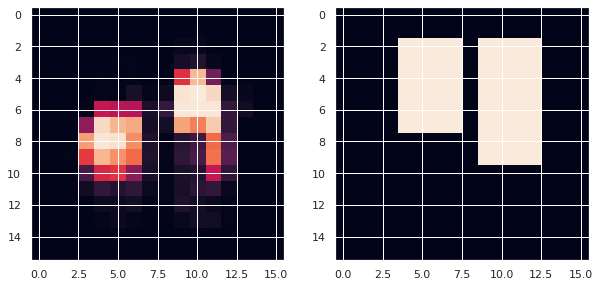

In [108]:
n = 4

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(y_train_predict[n].reshape(16,16))
axes[1].imshow(y_train_1[n]);

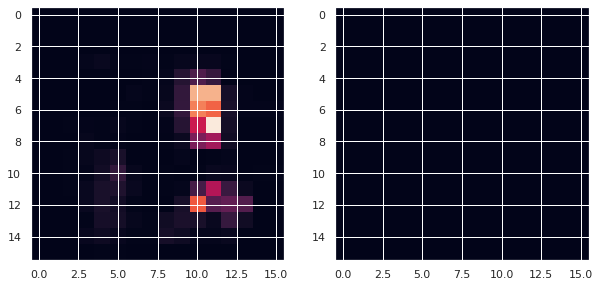

In [109]:
n = 48

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(y_train_predict[n].reshape(16,16))
axes[1].imshow(y_train_1[n]);
